# PART 3 - Evaluation of COMPAS dataset

#### Group Members : 
                Marck-Edward KEMEH - marck-edward.kemeh@grenoble-inp.org
                Irman FAQRIZAL - irman.faqrizal@univ-grenoble-alpes.fr
        

## 3.1 Fair Classifier
Machine Learning or data analysis which is one of the most used AI techniques relies heavily on dataand this data can be biased because it is provided by humans. such is the case for our case study "COMPASS Dataset". Most of the data provided as seen in our analysis in part 1 is highly biased against African- Americans being by gender or age category. African-American defendants were more vulnerable to be incorrectly labeled as higher-risk than they actually were when compared to their white defendants.

### 3.1.1 How to Achieve Fairness
1. Pre-processing

We decided to remove the sensitive features 'race' and 'gender' to build our classifier, expecting we will get better fairness.
2. Training Time

Since we will use neural network we can adjust hyperparameters such that we will get good results both on performance and fairness.
3. Post-Processing

In this problem we will not perform any post-processing because to derive a classifier is too complex of a task.


### 3.1.2 Criterias
There has been some proposal on achieving fairness on a dataset for classification or prediction. Most of these fairness criterias are based on the some of the following criterias;

          
           1.Demographic Parity / Independence
           2.Equalized odds / Seperation
           
#### 1. Independence
This refers to the notion that decision rates of the people involved in anything from the two different group must be equal. such groups can be race, gender, age category as seen from compass. In this part we will observe the independence by computing the acceptance ratio of two groups 'African-America' and 'Non African-American', then another two groups of gender 'Male' and 'Female'. 

#### 2. Separation
Separation and independence are mutually exclusive, because separation accept the probability of sensitive features correlated with the target values.  Separation can be achieved when when two different groups have relatively the same true positive rate and the same false positive rate. In this part we will focused on the ratio of FPR both for 'race' and 'gender'.

Based on the observation we did in the second part we will now build our own classifier which will hopefully performed better in terms of accuracy and fairness.

##### - Type of Classifier : Neural Network
We choose neural network since it performed quite well compared to other classifiers, when trying different type of classifiers. Another reason is that the possibilty of adjusting the hyperparameters of the network, and possibly the architecture to get better result.

##### - Features :
To increase fairness in our classifier we will remove the columns 'race' and 'sex'. We have seen on previous part that these two features are not necessarily affect the overall performance. Thus we expect by removing them we will gain fairness and still obtain good overall performance. 

In [1]:
# Increase my page width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import urllib
import os,sys
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
from pylab import rcParams
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, preprocessing
from random import seed, shuffle
from sklearn import preprocessing
RANDOM_SEED = 42

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file '%s' in the current directory...",fname)

    if fname not in files:
        print("'%s' not found! Downloading from GitHub...",fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("'%s' download and saved locally..",fname)
    else:
        print("File found in current directory..")
    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)
df=pd.read_csv('compas-scores-two-years.csv')

# preparing data by selecting needed colums and removing empty values
df = df[['race','sex', 'age_cat', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event', 'two_year_recid','score_text']]
df = df.dropna(how='any')

# Replace text with numbers
df['sex'].replace({'Male': 1, 'Female': 2}, inplace = True)
df['age_cat'].replace({'Greater than 45': 1, '25 - 45': 2, 'Less than 25': 3}, inplace = True)
df['c_charge_degree'].replace({'F': 1, 'M': 2}, inplace = True)
df['race'].replace({'Other': 1, 'African-American': 2, 'Caucasian': 3, 'Hispanic': 4, 'Native American': 5, 'Asian': 6}, inplace = True)
df['score_text'].replace({'Low': 0, 'Medium': 1, 'High' : 1}, inplace = True)

#splitting and converting data to tensor
X = df[['age_cat', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event']]
y = df[['two_year_recid']] #ground truth

# Arrange the data : Training, Testing, Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_SEED)

# X_train.astype(dtype = 'float32')
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_testnet = torch.from_numpy(X_test.to_numpy()).float()
y_testnet = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())
X_validate = torch.from_numpy(X_validate.to_numpy()).float()
y_validate = torch.squeeze(torch.from_numpy(y_validate.to_numpy()).float())

print("Training\t :"+ str(X_train.shape) +", "+ str(y_train.shape))
print("Testing\t\t :"+ str(X_testnet.shape) +", "+ str(y_testnet.shape))
print("Validation\t :"+ str(X_validate.shape) +", "+ str(y_validate.shape))


Looking for file '%s' in the current directory... compas-scores-two-years.csv
File found in current directory..
Training	 :torch.Size([5193, 8]), torch.Size([5193])
Testing		 :torch.Size([1443, 8]), torch.Size([1443])
Validation	 :torch.Size([578, 8]), torch.Size([578])


Below we redefined and then trained our network.

In [2]:
class Net(nn.Module):
  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 10)
    self.fc2 = nn.Linear(10, 10)
    self.fc3 = nn.Linear(10, 1)

  def forward(self, x):
    x = torch.tanh(self.fc1(x))
    x = torch.tanh(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

net = Net(X_train.shape[1])
print(net)

def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

max_epochs = 500
batch_size = 1100
batch_number = math.ceil(len(X_train)/batch_size)
for epoch in range (max_epochs):
    for batch_idx in range (batch_number):
        # Set up batch
        batch_end = ((batch_idx+1) * batch_size -1)
        batch_start = batch_idx * batch_size
        if (batch_idx == (batch_number-1)):
            batch_end = (len(X_train) -1)
        batch_x = X_train[batch_start : batch_end]
        batch_y = y_train[batch_start : batch_end]
        # Fit the training data and validate
        train_pred = net(batch_x)
        train_pred = torch.squeeze(train_pred)
        train_loss = criterion(train_pred, batch_y)
        train_acc = calculate_accuracy(batch_y, train_pred)
        y_validate_pred = net(X_validate)
        y_validate_pred = torch.squeeze(y_validate_pred)
        validate_loss = criterion(y_validate_pred, y_validate)
        validation_acc = calculate_accuracy(y_validate, y_validate_pred)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
        print( f'''epoch { {epoch} } \t==> Train : - Loss: {round_tensor(train_loss)}, Acc: {round_tensor(train_acc)} \t|| Validation : - Loss: {round_tensor(validate_loss)}, Acc: {round_tensor(validation_acc)}''')


Net(
  (fc1): Linear(in_features=8, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)
epoch {0} 	==> Train : - Loss: 0.716, Acc: 0.462 	|| Validation : - Loss: 0.722, Acc: 0.453
epoch {50} 	==> Train : - Loss: 0.325, Acc: 0.891 	|| Validation : - Loss: 0.326, Acc: 0.888
epoch {100} 	==> Train : - Loss: 0.305, Acc: 0.896 	|| Validation : - Loss: 0.297, Acc: 0.896
epoch {150} 	==> Train : - Loss: 0.302, Acc: 0.894 	|| Validation : - Loss: 0.294, Acc: 0.896
epoch {200} 	==> Train : - Loss: 0.299, Acc: 0.895 	|| Validation : - Loss: 0.292, Acc: 0.896
epoch {250} 	==> Train : - Loss: 0.297, Acc: 0.894 	|| Validation : - Loss: 0.29, Acc: 0.898
epoch {300} 	==> Train : - Loss: 0.295, Acc: 0.895 	|| Validation : - Loss: 0.29, Acc: 0.9
epoch {350} 	==> Train : - Loss: 0.294, Acc: 0.895 	|| Validation : - Loss: 0.289, Acc: 0.901
epoch {400} 	==> Train : - Loss: 0.293, Acc: 0.894 	|| Validation : - 

## 3.2 Evaluation
To evaluate the classifier we have built we will compute some metrices as in the previous parts, and then compare them with COMPAS classifier. As usual, the data we are using in here is testing data. This data will be used to get prediction results using our new classifier and compas classifier.

In [3]:
# filtering according to African-American
Xfair1 = X_test.loc[df['race'] == 2]
yfair1 = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['race']==2)]

Xfair2 = X_test.loc[df['race'] != 2]
yfair2 = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['race']!=2)]

# filtering according to sex
Xfair3 = X_test.loc[df['sex'] == 1]
yfair3 = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['sex']==1)]

Xfair4 = X_test.loc[df['sex'] == 2]
yfair4 = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['sex']==2)]

y_pred = net(X_testnet)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_testnet = y_testnet.cpu()
newacc = accuracy_score(y_testnet, y_pred)
newpre = precision_score(y_testnet, y_pred)
newrec = recall_score(y_testnet, y_pred)
print("===> Performance")
print(">> Accuracy\t: " + str(accuracy_score(y_testnet, y_pred)))
print(">> Precision\t: " + str(precision_score(y_testnet, y_pred)))
print(">> Recall\t: " + str(recall_score(y_testnet, y_pred)))
print("\n===> Fairness");
print(">> Race ===>")
Xfair1net = torch.from_numpy(Xfair1.to_numpy()).float()
y_pred = net(Xfair1net)
y_pred = y_pred.ge(.5).view(-1).cpu()
row1, row2 = confusion_matrix(yfair1, y_pred, labels=[1, 0])
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(Xfair1)
print("- African-American =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

Xfair2net = torch.from_numpy(Xfair2.to_numpy()).float()
y_pred = net(Xfair2net)
y_pred = y_pred.ge(.5).view(-1).cpu()
row1, row2 = confusion_matrix(yfair2, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/ len(Xfair2)
print("- Non African-American =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independence5 = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence5 = Pfair2_true/Pfair1_true
    
sept1n = tpr1/tpr2
if sept1n>1:
    sept1n = tpr2/tpr1
sepf5r = fpr1/fpr2
if sepf5r>1:
    sepf5r = fpr2/fpr1
    
print("-- Independence (Ratio) \t = " + str(round(independence5,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1n,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf5r,3)) )


print(">> Gender ===>")
Xfair3net = torch.from_numpy(Xfair3.to_numpy()).float()
y_pred = net(Xfair3net)
y_pred = y_pred.ge(.5).view(-1).cpu()
row1, row2 = confusion_matrix(yfair3, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0]) / len(Xfair3)
print("- Males =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

Xfair4net = torch.from_numpy(Xfair4.to_numpy()).float()
y_pred = net(Xfair4net)
y_pred = y_pred.ge(.5).view(-1).cpu()
row1, row2 = confusion_matrix(yfair4, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0]) / len(Xfair4)

print("- Females =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independence5g = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence5g = Pfair2_true/Pfair1_true
    
sept2n = tpr1/tpr2
if sept2n>1:
    sept2n = tpr2/tpr1
sepf5g = fpr1/fpr2
if sepf5g>1:
    sepf5g = fpr2/fpr1
    
print("-- Independence (Ratio) \t = " + str(round(independence5g,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept2n,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf5g,3)) )

===> Performance
>> Accuracy	: 0.9099099099099099
>> Precision	: 0.9406474820143885
>> Recall	: 0.8435483870967742

===> Fairness
>> Race ===>
- African-American =>
True Positive Rate	 = 0.8440860215053764
False Positive Rate	 = 0.055710306406685235
Acceptance rate		 = 0.45690834473324216
- Non African-American =>
True Positive Rate	 = 0.842741935483871
False Positive Rate	 = 0.028017241379310345
Acceptance rate		 = 0.31179775280898875
-- Independence (Ratio) 	 = 0.682
-- Separation (TPR Ratio) 	 = 0.998
-- Separation (FPR Ratio) 	 = 0.503
>> Gender ===>
- Males =>
True Positive Rate	 = 0.8440860215053764
False Positive Rate	 = 0.055710306406685235
Acceptance rate		 = 0.40402347024308466
- Females =>
True Positive Rate	 = 0.8235294117647058
False Positive Rate	 = 0.024242424242424242
Acceptance rate		 = 0.296
-- Independence (Ratio) 	 = 0.733
-- Separation (TPR Ratio) 	 = 0.976
-- Separation (FPR Ratio) 	 = 0.435


In [4]:
y_compas = df[['score_text']].iloc[y_test.index.tolist(), :]
y_true = df[['two_year_recid']].iloc[y_test.index.tolist(), :]

comacc = accuracy_score(y_true, y_compas)
compre = precision_score(y_true, y_compas)
comrec = recall_score(y_true, y_compas)
print("===> Performance")
print(">> Accuracy\t: " + str(accuracy_score(y_true, y_compas)))
print(">> Precision\t: " + str(precision_score(y_true, y_compas)))
print(">> Recall\t: " + str(recall_score(y_true, y_compas)))

print("\n===> Fairness")
print(">> Race ===>")
print("- African-American =>")
y_compas = df[['score_text']].iloc[y_test.index.tolist(), :].loc[(df['race']==2)]
y_true = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['race']==2)]
tmpaccuracy = accuracy_score(y_true, y_compas)
row1, row2 = confusion_matrix(y_true, y_compas, labels=[1, 0])
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(y_compas)
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

print("- Non African-American =>")
y_compas = df[['score_text']].iloc[y_test.index.tolist(), :].loc[(df['race']!=2)]
y_true = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['race']!=2)]
tmpaccuracy = accuracy_score(y_true, y_compas)
row1, row2 = confusion_matrix(y_true, y_compas, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/len(y_compas)
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independencec = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independencec = Pfair2_true/Pfair1_true
    
sept1c = tpr1/tpr2
if sept1c>1:
    sept1c = tpr2/tpr1
sepf5c = fpr1/fpr2
if sepf5c>1:
    sepf5c = fpr2/fpr1
    
print("-- Independence (Ratio) \t = " + str(round(independencec,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1c,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf5c,3)) )


print(">> Gender ===>")
print("- Male =>")
y_compas = df[['score_text']].iloc[y_test.index.tolist(), :].loc[(df['sex']==1)]
y_true = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['sex']==1)]
tmpaccuracy = accuracy_score(y_true, y_compas)
row1, row2 = confusion_matrix(y_true, y_compas, labels=[1, 0])
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(y_compas)
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

print("- Female =>")
y_compas = df[['score_text']].iloc[y_test.index.tolist(), :].loc[(df['sex']==2)]
y_true = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['sex']==2)]
tmpaccuracy = accuracy_score(y_true, y_compas)
row1, row2 = confusion_matrix(y_true, y_compas, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/len(y_compas)
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independencecf = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independencecf = Pfair2_true/Pfair1_true
    
sept2c = tpr1/tpr2
if sept2c>1:
    sept2c = tpr2/tpr1
sepf5cf = fpr1/fpr2
if sepf5cf>1:
    sepf5cf = fpr2/fpr1
    
print("-- Independence (Ratio) \t = " + str(round(independencecf,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept2c,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf5cf,3)) )

===> Performance
>> Accuracy	: 0.6555786555786556
>> Precision	: 0.5919282511210763
>> Recall	: 0.6387096774193548

===> Fairness
>> Race ===>
- African-American =>
True Positive Rate	 = 0.7419354838709677
False Positive Rate	 = 0.4428969359331476
Acceptance rate		 = 0.5950752393980848
- Non African-American =>
True Positive Rate	 = 0.4838709677419355
False Positive Rate	 = 0.24568965517241378
Acceptance rate		 = 0.32865168539325845
-- Independence (Ratio) 	 = 0.552
-- Separation (TPR Ratio) 	 = 0.652
-- Separation (FPR Ratio) 	 = 0.555
>> Gender ===>
- Male =>
True Positive Rate	 = 0.6467289719626168
False Positive Rate	 = 0.33282674772036475
Acceptance rate		 = 0.47359597652975693
- Female =>
True Positive Rate	 = 0.5882352941176471
False Positive Rate	 = 0.32727272727272727
Acceptance rate		 = 0.416
-- Independence (Ratio) 	 = 0.878
-- Separation (TPR Ratio) 	 = 0.91
-- Separation (FPR Ratio) 	 = 0.983


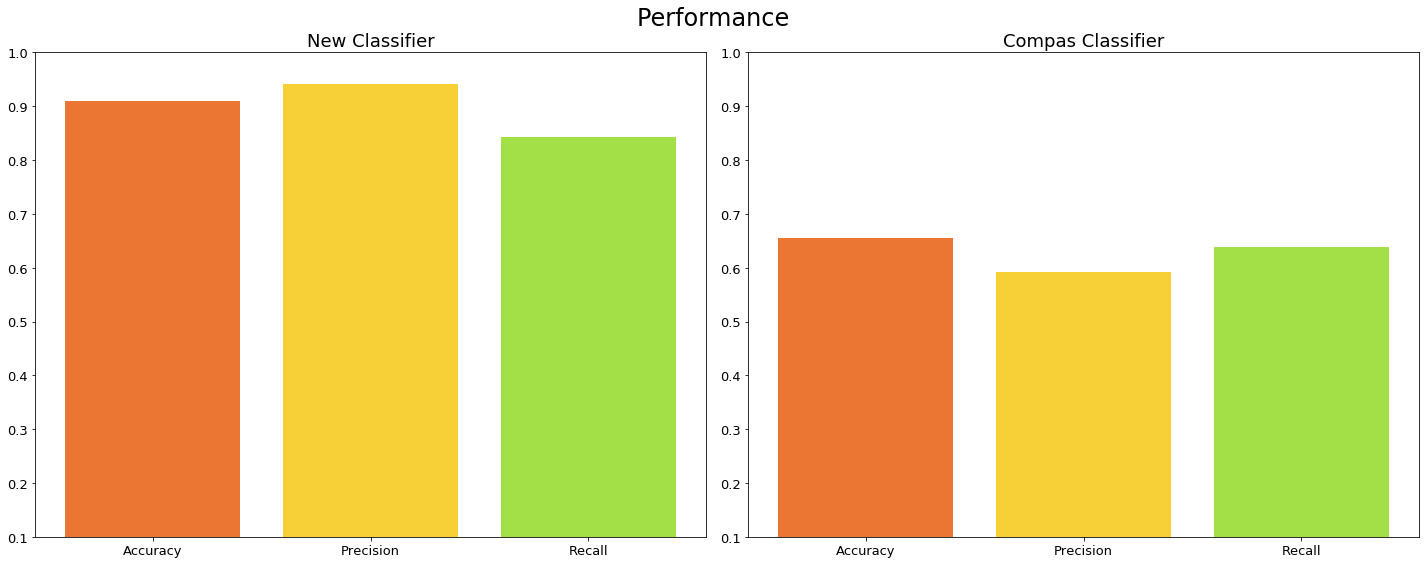

In [5]:
plt.rcParams.update({'font.size': 13})
classf = ['Accuracy', 'Precision', 'Recall']
new = [newacc, newpre, newrec]
com = [comacc, compre, comrec]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
fig.suptitle('Performance', fontsize=24)
axes[0].set_title('New Classifier', fontsize=18)
axes[0].bar(classf, new, color=['#eb7532','#f7d038','#a3e048'])
axes[0].set_ylim([0.1,1])
axes[1].set_title('Compas Classifier', fontsize=18)
axes[1].bar(classf, com, color=['#eb7532','#f7d038','#a3e048'])
axes[1].set_ylim([0.1,1])
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

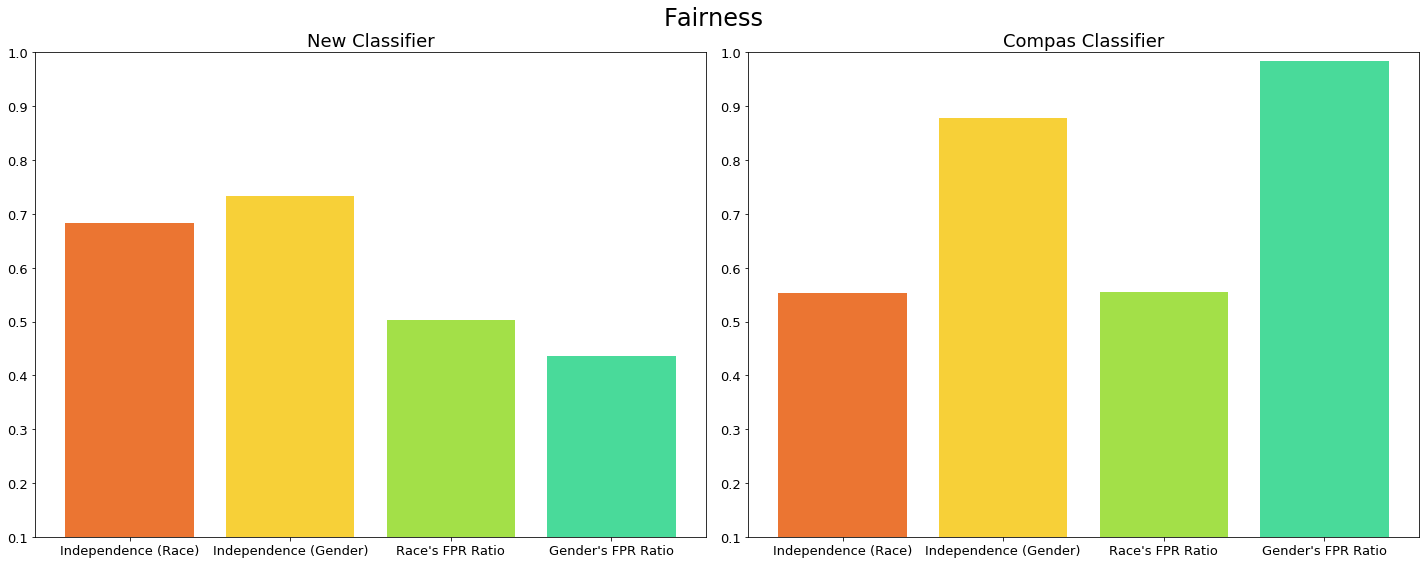

In [6]:
classf = ['Independence (Race)', 'Independence (Gender)', 'Race\'s FPR Ratio', 'Gender\'s FPR Ratio']
new = [independence5, independence5g, sepf5r, sepf5g]
com = [independencec, independencecf, sepf5c, sepf5cf]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
fig.suptitle('Fairness', fontsize=24)
axes[0].set_title('New Classifier', fontsize=18)
axes[0].bar(classf, new, color=['#eb7532','#f7d038','#a3e048','#49da9a'])
axes[0].set_ylim([0.1,1])
axes[1].set_title('Compas Classifier', fontsize=18)
axes[1].bar(classf, com, color=['#eb7532','#f7d038','#a3e048','#49da9a'])
axes[1].set_ylim([0.1,1])
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

## 3.3 Conclusion
Based on the graphs above we can see that in term of performance our new classifier performs significantly better than compass classifier. However the compas classifier relatively better on fairness. This is an indication that removing the sensitive features does not necessary guarantee the fairness of a classifier.